В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [342]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    def __init__(self, accuracy, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.accuracy = accuracy
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = len(hidden_layer_sizes) + 1
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        W = list()
        b = list()
        
        h = list(self.hidden_layer_sizes)
        h.insert(0, n_x)
        h.append(1)
        hidden_layers = tuple(h)
        
        for i in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i-1]) * 0.01)
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}
                    
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = []
        Z = []
        
        for i in range(0, self.n_layers):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
                       
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        
        for i in range(self.n_layers-1, 0, -1):
            dA[i-1] = np.dot(W[i].T, dZ[i])
            dZ[i-1] = np.multiply(dA[i-1], np.multiply(A[i-1], 1 - A[i-1]))
            if i-1 == 0:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)        
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x)

        for i in range(self.num_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            costs.append(cost)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)
            
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
                
            if i > 1 and abs(cost-costs[-2]) < self.accuracy:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [343]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [344]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


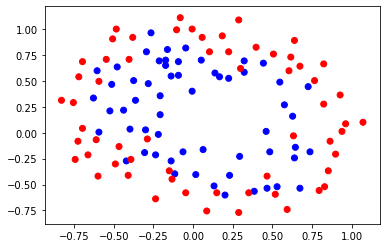

In [345]:
plot_data(X, Y)

In [367]:
cls = NeuralNet(
    accuracy=1e-12,
    hidden_layer_sizes=(20,15), 
    normalize = True, 
    learning_rate = 0.52, 
    num_iter = 14001)

0-th iteration: 0.6930247290928906
1000-th iteration: 0.693003405612414
2000-th iteration: 0.6930032620434847
3000-th iteration: 0.6930030553700182
4000-th iteration: 0.6930027247541808
5000-th iteration: 0.6930021429672341
6000-th iteration: 0.693001004100446
7000-th iteration: 0.6929984346540562
8000-th iteration: 0.6929912489315059
9000-th iteration: 0.6929621697845946
10000-th iteration: 0.6927104631163233
11000-th iteration: 0.6893617527506413
12000-th iteration: 0.6606372812262632
13000-th iteration: 0.3949656408906559
14000-th iteration: 0.3314513135175637


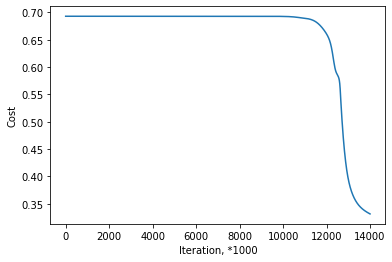

In [368]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [369]:
print(cls.parameters)

{'W': [array([[-0.54445644, -0.41254114],
       [-0.54650346, -0.41603407],
       [ 0.52500011,  0.32081625],
       [ 0.51857156,  0.33358165],
       [-0.48494369, -0.38253239],
       [ 0.52269332,  0.34347409],
       [ 0.51134749,  0.33924457],
       [-0.62232901, -0.4507765 ],
       [-0.51296459, -0.37739892],
       [-0.51226364, -0.3793178 ],
       [ 0.09332265, -2.28894494],
       [ 0.25280967,  0.30611884],
       [ 0.85699432, -0.43407871],
       [-0.87064953,  0.77786112],
       [ 0.50864175,  0.36965667],
       [-0.58659789, -0.42242469],
       [ 0.52767904,  0.31192321],
       [ 0.53131778,  0.30735616],
       [-0.08294706,  0.07491641],
       [ 0.38475885,  0.14101375]]), array([[-1.88776941e-01, -1.75386981e-01,  4.84104279e-01,
         4.41577043e-01, -2.60604158e-01,  4.18756165e-01,
         4.27166807e-01, -8.36138141e-01, -5.49473951e-01,
        -4.36777354e-01, -3.09692831e+00,  1.81430014e-01,
         1.96802900e+00, -1.72351901e+00,  2.76063563e-

In [370]:
Y_prob = cls.predict_proba(X_test)
Y_prob

array([[0.05009886, 0.94990114],
       [0.15445788, 0.84554212],
       [0.03508346, 0.96491654],
       [0.05822888, 0.94177112],
       [0.87922103, 0.12077897],
       [0.98879327, 0.01120673],
       [0.54719665, 0.45280335],
       [0.68451193, 0.31548807],
       [0.06031484, 0.93968516],
       [0.21479601, 0.78520399],
       [0.03041887, 0.96958113],
       [0.15883178, 0.84116822],
       [0.89357223, 0.10642777],
       [0.00936927, 0.99063073],
       [0.33689918, 0.66310082],
       [0.4884027 , 0.5115973 ],
       [0.0327815 , 0.9672185 ],
       [0.99334229, 0.00665771],
       [0.04477864, 0.95522136],
       [0.91354824, 0.08645176],
       [0.81677494, 0.18322506],
       [0.07333536, 0.92666464],
       [0.17025569, 0.82974431],
       [0.31991321, 0.68008679]])

In [371]:
Y_hat = cls.predict(X_test)
Y_hat

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0])

In [372]:
accuracy_score(y_test, Y_hat)

0.875

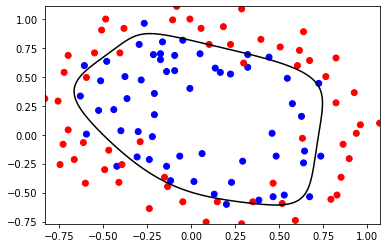

In [373]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

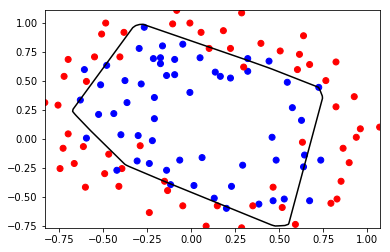

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8389830508474576